In [2]:
# import sys
# sys.path.append("/Users/yw11823/ACSE/irp/spyro")

import os
os.environ["OMP_NUM_THREADS"] = "1"

from firedrake import *
import numpy as np
import finat
from ROL.firedrake_vector import FiredrakeVector as FeVector
import ROL
from mpi4py import MPI
import psutil

import spyro
import time

import meshio
from SeismicMesh import *
import segyio


In [6]:
try:
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    from matplotlib import cm
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    mpl.rc('font', size=16)
    mpl.rc('figure', figsize=(10, 7))
except:
    plt = None
    cm = None    
def plot_shotrecord(rec, model, scale, colorbar=True):
    """
    Plot a shot record (receiver values over time).

    Parameters
    ----------
    rec :
        Receiver data with shape (time, points).
    model : Model
        object that holds the velocity model.
    t0 : int
        Start of time dimension to plot.
    tn : int
        End of time dimension to plot.
    """
    scale = np.max(rec) / 10.0
    # scale = scale
    extent = [0, model["mesh"]["Lx"],
              model["timeaxis"]["tf"], model["timeaxis"]["t0"] ]


    plot = plt.imshow(rec, vmin=-scale, vmax=scale, cmap=cm.gray, extent=extent)
    plt.xlabel('X position (km)')
    plt.ylabel('Time (s)')

    # Create aligned colorbar on the right
    if colorbar:
        ax = plt.gca()
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(plot, cax=cax)
    plt.show()

In [7]:
import pickle
import numpy as np

def load_shots(file_name=None):
    """Load a `pickle` to a `numpy.ndarray`.

    Parameters
    ----------
    filename: str, optional by default shot_number_#.dat
        The filename to save the data as a `pickle`

    Returns
    -------
    array: `numpy.ndarray`
        The data

    """

    with open(file_name, "rb") as f:
        array = np.asarray(pickle.load(f), dtype=float)
    return array

# Forward modeling

## Zero example: One layer velocity model

In [149]:
from firedrake import (
    RectangleMesh,
    FunctionSpace,
    Function,
    SpatialCoordinate,
    conditional,
    File,
)

import spyro

model = {}

# Choose method and parameters
model["opts"] = {
    "method": "KMV",  # either CG or KMV
    "quadrature": "KMV", # Equi or KMV
    "degree": 2,  # p order
    "dimension": 2,  # dimension
}

# Number of cores for the shot. For simplicity, we keep things serial.
# spyro however supports both spatial parallelism and "shot" parallelism.
model["parallelism"] = {
    "type": "spatial",  # options: automatic (same number of cores for evey processor) or spatial
}

# Define the domain size without the PML. Here we'll assume a 0.75 x 1.50 km
# domain and reserve the remaining 250 m for the Perfectly Matched Layer (PML) to absorb
# outgoing waves on three sides (eg., -z, +-x sides) of the domain.
model["mesh"] = {
    "Lz": 1.0,  # depth in km - always positive
    "Lx": 1.0,  # width in km - always positive
    "Ly": 0.0,  # thickness in km - always positive
    "meshfile": "not_used.msh",
    "initmodel": "not_used.hdf5",
    "truemodel": "not_used.hdf5",
}

# Specify a 250-m PML on the three sides of the domain to damp outgoing waves.
model["BCs"] = {
    "status": True,  # True or false
    "outer_bc": "non-reflective",  #  None or non-reflective (outer boundary condition)
    "damping_type": "polynomial",  # polynomial, hyperbolic, shifted_hyperbolic
    "exponent": 2,  # damping layer has a exponent variation
    "cmax": 4.7,  # maximum acoustic wave velocity in PML - km/s
    "R": 1e-6,  # theoretical reflection coefficient
    "lz": 0.1,  # thickness of the PML in the z-direction (km) - always positive
    "lx": 0.1,  # thickness of the PML in the x-direction (km) - always positive
    "ly": 0.0,  # thickness of the PML in the y-direction (km) - always positive
}

# Create a source injection operator. Here we use a single source with a
# Ricker wavelet that has a peak frequency of 8 Hz injected at the center of the mesh.
# We also specify to record the solution at 101 microphones near the top of the domain.
# This transect of receivers is created with the helper function `create_transect`.
model["acquisition"] = {
    "source_type": "Ricker",
    "source_pos": [(0.5, 0.98)],
    "frequency": 10.0,
    "delay": 0.0,
    "receiver_locations": spyro.create_transect(
        (0.0, 0.98), (1.0, 0.98), 101
    ),
}

# Simulate for 1.0 seconds.
model["timeaxis"] = {
    "t0": 0.0,  #  Initial time for event
    "tf": 1.00,  # Final time for event
    "dt": 0.0005,  # timestep size
    "amplitude": 1,  # the Ricker has an amplitude of 1.
    "nspool": 100,  # how frequently to output solution to pvds
    "fspool": 100,  # how frequently to save solution to RAM
}


# Create a simple mesh of a rectangle ∈ [1 x 2] km with ~100 m sized elements
# and then create a function space for P=1 Continuous Galerkin FEM
mesh = RectangleMesh(100, 100, 1.0, 1.0)

# We edit the coordinates of the mesh so that it's in the (z, x) plane
# and has a domain padding of 250 m on three sides, which will be used later to show
# the Perfectly Matched Layer (PML). More complex 2D/3D meshes can be automatically generated with
# SeismicMesh https://github.com/krober10nd/SeismicMesh
# mesh.coordinates.dat.data[:, 0] -= 1.0
# mesh.coordinates.dat.data[:, 1] -= 0.25


# Create the computational environment
comm = spyro.utils.mpi_init(model)

element = spyro.domains.space.FE_method(
    mesh, model["opts"]["method"], model["opts"]["degree"]
)
V = FunctionSpace(mesh, element)

# Manually create a simple two layer seismic velocity model `vp`.
# Note: the user can specify their own velocity model in a HDF5 file format
# in the above two lines using SeismicMesh.
# If so, the HDF5 file has to contain an array with
# the velocity data and it is linearly interpolated onto the mesh nodes at run-time.
x, y = SpatialCoordinate(mesh)
velocity = conditional(y > 0.5, 1.5, 2.5)
vp = Function(V, name="velocity").interpolate(velocity)
# These pvd files can be easily visualized in ParaView!
File("simple_velocity_model.pvd").write(vp)


# Now we instantiate both the receivers and source objects.
sources = spyro.Sources(model, mesh, V, comm)

receivers = spyro.Receivers(model, mesh, V, comm)

# Create a wavelet to force the simulation
wavelet = spyro.full_ricker_wavelet(dt=0.0005, tf=1.0, freq=10.0)

# And now we simulate the shot using a 2nd order central time-stepping scheme
# Note: simulation results are stored in the folder `~/results/` by default
p_field, p_at_recv = spyro.solvers.forward(
     model, mesh, comm, vp, sources, wavelet, receivers, output=True
)

# # Visualize the shot record
# spyro.plots.plot_shots(model, comm, p_at_recv, file_name = "simple", vmax = 1e-3, vmin = -1e-3)

# Save the shot (a Numpy array) as a pickle for other use.
spyro.io.save_shots(model, comm, p_at_recv, file_name = "rec_ex0_")

# # can be loaded back via
# my_shot = spyro.io.load_shots(model, comm)

/Users/yw11823/ACSE/irp/firedrake/src/firedrake/firedrake/_deprecation.py:65: UserWarning: The use of `File` for output is deprecated, please update your code to use `VTKFile` from `firedrake.output`.
  warn(
/Users/yw11823/ACSE/irp/firedrake/src/firedrake/firedrake/function.py:325: FutureWarning: The .split() method is deprecated, please use the .subfunctions property instead
  warnings.warn("The .split() method is deprecated, please use the .subfunctions property instead", category=FutureWarning)
/Users/yw11823/ACSE/irp/firedrake/src/firedrake/firedrake/_deprecation.py:65: UserWarning: The use of `File` for output is deprecated, please update your code to use `VTKFile` from `firedrake.output`.
  warn(
/Users/yw11823/ACSE/irp/firedrake/src/ufl/ufl/utils/sorting.py:84: UserWarning: Applying str() to a metadata value of type QuadratureRule, don't know if this is safe.
  warnings.warn(f"Applying str() to a metadata value of type {type(value).__name__}, "
/Users/yw11823/ACSE/irp/firedrake

Simulation time is:     0.0495 seconds


/Users/yw11823/ACSE/irp/firedrake/src/firedrake/firedrake/function.py:325: FutureWarning: The .split() method is deprecated, please use the .subfunctions property instead
  warnings.warn("The .split() method is deprecated, please use the .subfunctions property instead", category=FutureWarning)


Simulation time is:     0.0995 seconds


/Users/yw11823/ACSE/irp/firedrake/src/firedrake/firedrake/function.py:325: FutureWarning: The .split() method is deprecated, please use the .subfunctions property instead
  warnings.warn("The .split() method is deprecated, please use the .subfunctions property instead", category=FutureWarning)


Simulation time is:     0.1495 seconds


/Users/yw11823/ACSE/irp/firedrake/src/firedrake/firedrake/function.py:325: FutureWarning: The .split() method is deprecated, please use the .subfunctions property instead
  warnings.warn("The .split() method is deprecated, please use the .subfunctions property instead", category=FutureWarning)


Simulation time is:     0.1995 seconds


/Users/yw11823/ACSE/irp/firedrake/src/firedrake/firedrake/function.py:325: FutureWarning: The .split() method is deprecated, please use the .subfunctions property instead
  warnings.warn("The .split() method is deprecated, please use the .subfunctions property instead", category=FutureWarning)


Simulation time is:     0.2495 seconds


/Users/yw11823/ACSE/irp/firedrake/src/firedrake/firedrake/function.py:325: FutureWarning: The .split() method is deprecated, please use the .subfunctions property instead
  warnings.warn("The .split() method is deprecated, please use the .subfunctions property instead", category=FutureWarning)


Simulation time is:     0.2995 seconds


/Users/yw11823/ACSE/irp/firedrake/src/firedrake/firedrake/function.py:325: FutureWarning: The .split() method is deprecated, please use the .subfunctions property instead
  warnings.warn("The .split() method is deprecated, please use the .subfunctions property instead", category=FutureWarning)


Simulation time is:     0.3495 seconds


/Users/yw11823/ACSE/irp/firedrake/src/firedrake/firedrake/function.py:325: FutureWarning: The .split() method is deprecated, please use the .subfunctions property instead
  warnings.warn("The .split() method is deprecated, please use the .subfunctions property instead", category=FutureWarning)


Simulation time is:     0.3995 seconds


/Users/yw11823/ACSE/irp/firedrake/src/firedrake/firedrake/function.py:325: FutureWarning: The .split() method is deprecated, please use the .subfunctions property instead
  warnings.warn("The .split() method is deprecated, please use the .subfunctions property instead", category=FutureWarning)


Simulation time is:     0.4495 seconds


/Users/yw11823/ACSE/irp/firedrake/src/firedrake/firedrake/function.py:325: FutureWarning: The .split() method is deprecated, please use the .subfunctions property instead
  warnings.warn("The .split() method is deprecated, please use the .subfunctions property instead", category=FutureWarning)


Simulation time is:     0.4995 seconds


/Users/yw11823/ACSE/irp/firedrake/src/firedrake/firedrake/function.py:325: FutureWarning: The .split() method is deprecated, please use the .subfunctions property instead
  warnings.warn("The .split() method is deprecated, please use the .subfunctions property instead", category=FutureWarning)


Simulation time is:     0.5495 seconds


/Users/yw11823/ACSE/irp/firedrake/src/firedrake/firedrake/function.py:325: FutureWarning: The .split() method is deprecated, please use the .subfunctions property instead
  warnings.warn("The .split() method is deprecated, please use the .subfunctions property instead", category=FutureWarning)


Simulation time is:     0.5995 seconds


/Users/yw11823/ACSE/irp/firedrake/src/firedrake/firedrake/function.py:325: FutureWarning: The .split() method is deprecated, please use the .subfunctions property instead
  warnings.warn("The .split() method is deprecated, please use the .subfunctions property instead", category=FutureWarning)


Simulation time is:     0.6495 seconds


/Users/yw11823/ACSE/irp/firedrake/src/firedrake/firedrake/function.py:325: FutureWarning: The .split() method is deprecated, please use the .subfunctions property instead
  warnings.warn("The .split() method is deprecated, please use the .subfunctions property instead", category=FutureWarning)


Simulation time is:     0.6995 seconds


/Users/yw11823/ACSE/irp/firedrake/src/firedrake/firedrake/function.py:325: FutureWarning: The .split() method is deprecated, please use the .subfunctions property instead
  warnings.warn("The .split() method is deprecated, please use the .subfunctions property instead", category=FutureWarning)


Simulation time is:     0.7495 seconds


/Users/yw11823/ACSE/irp/firedrake/src/firedrake/firedrake/function.py:325: FutureWarning: The .split() method is deprecated, please use the .subfunctions property instead
  warnings.warn("The .split() method is deprecated, please use the .subfunctions property instead", category=FutureWarning)


Simulation time is:     0.7995 seconds


/Users/yw11823/ACSE/irp/firedrake/src/firedrake/firedrake/function.py:325: FutureWarning: The .split() method is deprecated, please use the .subfunctions property instead
  warnings.warn("The .split() method is deprecated, please use the .subfunctions property instead", category=FutureWarning)


Simulation time is:     0.8495 seconds


/Users/yw11823/ACSE/irp/firedrake/src/firedrake/firedrake/function.py:325: FutureWarning: The .split() method is deprecated, please use the .subfunctions property instead
  warnings.warn("The .split() method is deprecated, please use the .subfunctions property instead", category=FutureWarning)


Simulation time is:     0.8995 seconds


/Users/yw11823/ACSE/irp/firedrake/src/firedrake/firedrake/function.py:325: FutureWarning: The .split() method is deprecated, please use the .subfunctions property instead
  warnings.warn("The .split() method is deprecated, please use the .subfunctions property instead", category=FutureWarning)


Simulation time is:     0.9495 seconds


/Users/yw11823/ACSE/irp/firedrake/src/firedrake/firedrake/function.py:325: FutureWarning: The .split() method is deprecated, please use the .subfunctions property instead
  warnings.warn("The .split() method is deprecated, please use the .subfunctions property instead", category=FutureWarning)


### Plot velocity model and source wavelet

In [ ]:

# Create a wavelet to force the simulation
wavelet = spyro.full_ricker_wavelet(dt=0.0005, tf=1.0, freq=10.0)

In [ ]:
# Create a wavelet to force the simulation
wavelet = spyro.rricker_wavelet(
    t = , freq, amp=1.0, delay=0, delay_type="time"
)

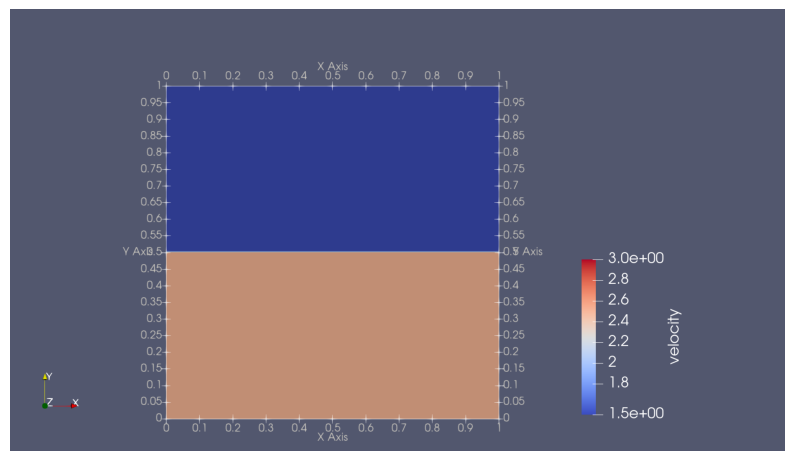

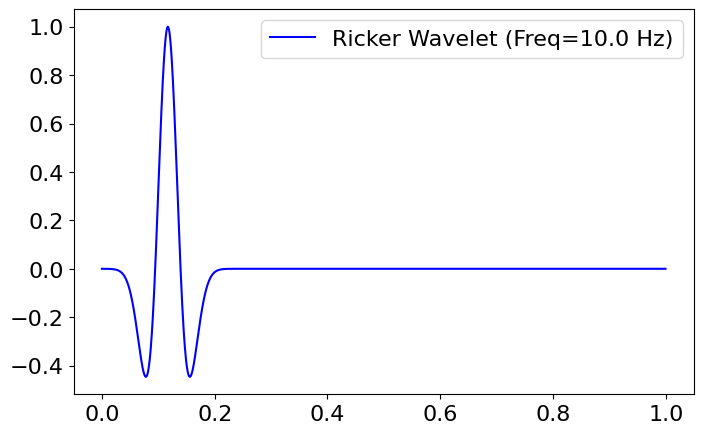

In [150]:
import matplotlib.image as mpimg
# plot the velocity model graph
img = mpimg.imread('/Users/yw11823/ACSE/irp/spyro/simple_model.png')
fig, ax = plt.subplots(figsize=(10, 6))  # 可以调整figsize的值来设置图形的大小
imgplot = ax.imshow(img)
ax.axis('off')
plt.show()

# plot the graph of the source wavelets
wavelet = spyro.full_ricker_wavelet( dt= model["timeaxis"]["dt"], tf = model["timeaxis"]["tf"], freq= model["acquisition"]["frequency"])
plt.figure(figsize=(8, 5))
plt.plot( np.arange(wavelet.shape[0]) * model["timeaxis"]["dt"],  wavelet, color='blue', linewidth=1.5, label=f'Ricker Wavelet (Freq={model["acquisition"]["frequency"]} Hz)')
plt.legend()
plt.show()

In [152]:
wavelet.shape

(2000,)

In [153]:
wavelet

array([-3.56449362e-05, -3.96420389e-05, -4.40637937e-05, ...,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00])

In [154]:
# Save rec1 as a .dat file
np.savetxt("src_spyro.dat", wavelet[:])

### Plot shot records

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [5.73747697e-06 4.35567841e-06 3.00169304e-06 ... 3.00206346e-06
  4.35250852e-06 5.73299907e-06]
 [5.63253214e-06 4.26753983e-06 2.93236892e-06 ... 2.93216228e-06
  4.26520401e-06 5.62846507e-06]
 [5.52902500e-06 4.17974354e-06 2.86345653e-06 ... 2.86243091e-06
  4.17807062e-06 5.52523912e-06]]
(2000, 100)
[Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x426d478d0>, FiniteElement('Kong-Mulder-Veldhuizen', triangle, 2, variant='KMV'), name=None), Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 17747)), 35625), Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x426d478d0>, FiniteElement('Kong-Mulder-Veldhuizen'

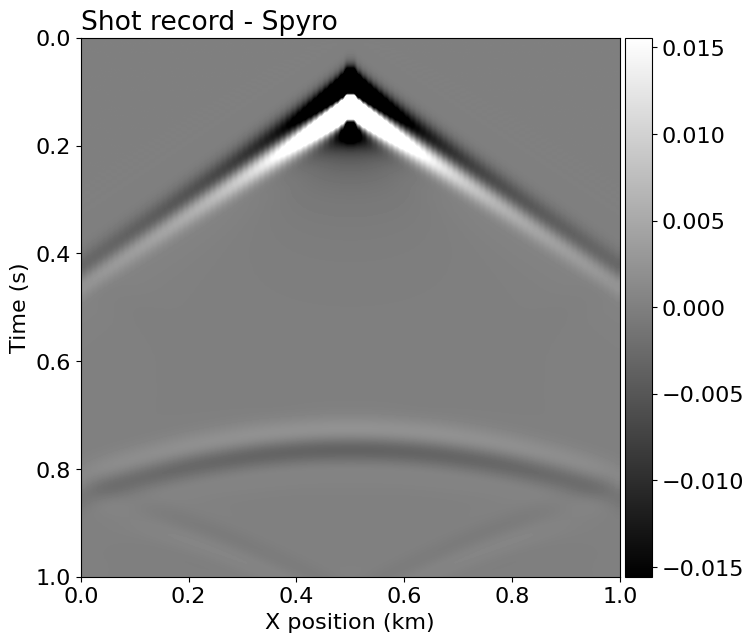

In [131]:
print(p_at_recv)
print(p_at_recv.shape)
print(p_field)
print("min:",np.min(p_at_recv))
print("max:",np.max(p_at_recv))
plt.title('Shot record - Spyro', loc='left')
plot_shotrecord(p_at_recv, model, d0, tf) 

## First example: simple circle velocity model
### 1. Construct the model, mesh, acquisition geometry
1. sources num = 1
2. receivers num =101
3. mesh $1.0km \times 1.0km$ 
4. pml = 0.4 km 
5. Ricker feq = 10 HZ 
6. tf = 1s, dt=0.000408s 
7. p_order = 4, suggested


In [76]:
sou_pos = [(0.02, 0.5)]
rec_pos = spyro.create_transect((0.98, 0.0), (0.98, 1.0), 101)

model = {}
model["opts"] = {
    "method": "KMV",  # either CG or KMV
    "quadrature": "KMV",  # Equi or KMV
    "degree": 1,  # p order
    "dimension": 2,  # dimension
    # "regularization": False,  # regularization is on?
    # "gamma": 1.0,  # regularization parameter
}
model["parallelism"] = {
    "type": "spatial", 
}
model["mesh"] = {
    "Lz": 1.0,  # depth in km - always positive
    "Lx": 1.0,  # width in km - always positive
    "Ly": 0.0,  # thickness in km - always positive
    "meshfile": "not_used.msh", 
    "initmodel": "not_used.hdf5", 
    "truemodel": "not_used.hdf5", 
}
model["BCs"] = {
    "status": True,  # True or false
    "outer_bc": "non-reflective",  # None or non-reflective (outer boundary condition)
    "damping_type": "polynomial",  # polynomial, hyperbolic, shifted_hyperbolic
    "exponent": 2,  # damping layer has a exponent variation
    "cmax": 4.5,  # maximum acoustic wave velocity in PML - km/s
    "R": 1e-6,  # theoretical reflection coefficient
    "lz": 0.4,  # thickness of the PML in the z-direction (km) - always positive
    "lx": 0.4,  # thickness of the PML in the x-direction (km) - always positive
    "ly": 0.0,  # thickness of the PML in the y-direction (km) - always positive
}
model["acquisition"] = {
    "source_type": "Ricker", 
    "source_pos": sou_pos, 
    "frequency": 10.0,  # frequency of source wavelet = 10 hz 
    # "delay": 0.1, 
    "delay": 0.1, 
    "receiver_locations": rec_pos, 
}
model["timeaxis"] = {
    "t0": 0.0,  # Initial time for event
    "tf": 1.00,  # Final time for event
    "dt": 0.000408,  # to match the dt.critical in Devito
    # "dt": 0.0005,
    "amplitude": 1,  # the Ricker has an amplitude of 1 
    "nspool": 100,  # how frequently to output solution to pvds
    "fspool": 1,  # how frequently to save solution to RAM
    "skip": 4,
}

# mesh = RectangleMesh(101, 101, 1.0, 1.0) # size of the mesh: 1 x 1 km
# mesh = PeriodicRectangleMesh(200, 200,1,1) # this is not workable in the current case
mesh = UnitSquareMesh(300, 300) # 1000 cells in x-direction and The number of cells in the y direction = 1000

comm = spyro.utils.mpi_init(model)
element = spyro.domains.space.FE_method(mesh, model["opts"]["method"], model["opts"]["degree"])
V = FunctionSpace(mesh, element)

# Create a simple two-layer seismic velocity model `vp`.
x, y = SpatialCoordinate(mesh)
radius = 0.15
center_x, center_y = 0.5, 0.5
condition = (x - center_x)**2 + (y - center_y)**2 < radius**2
velocity = conditional(condition, 3.0, 2.5)
vp = Function(V, name="velocity").interpolate(velocity)
File("true_velocity_model_circle.pvd").write(vp)

sources = spyro.Sources(model, mesh, V, comm)
receivers = spyro.Receivers(model, mesh, V, comm)

d0=model["timeaxis"]["t0"]
dt=model["timeaxis"]["dt"]
tf=model["timeaxis"]["tf"]
freq=model["acquisition"]["frequency"]
wavelet = spyro.full_ricker_wavelet( dt= dt, tf = tf, freq= freq)

# Calculate running time
start_time = time.time()
p_field, p_at_recv = spyro.solvers.forward(model, mesh, comm, vp, sources, wavelet, receivers)
end_time = time.time()
running_time = end_time - start_time
print("Running Time: {:.2f} seconds".format(running_time))

# Save the shot (a Numpy array) as a pickle for other use.
# spyro.io.save_shots(model, comm, p_field, file_name="p_field_ex1_")
spyro.io.save_shots(model, comm, p_at_recv, file_name="rec_ex1_")

/Users/yw11823/ACSE/irp/firedrake/src/firedrake/firedrake/_deprecation.py:65: UserWarning: The use of `File` for output is deprecated, please update your code to use `VTKFile` from `firedrake.output`.
  warn(


### 2. Plot the velocity model, source wavelet
velocity model can be visualized in the file true_velocity_model_circle.pvd

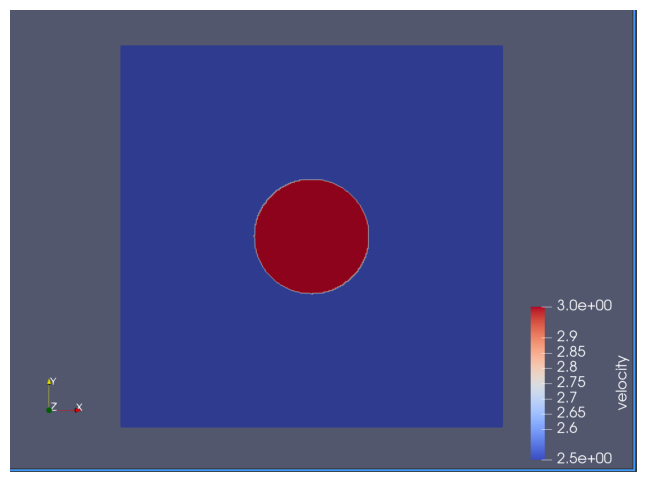

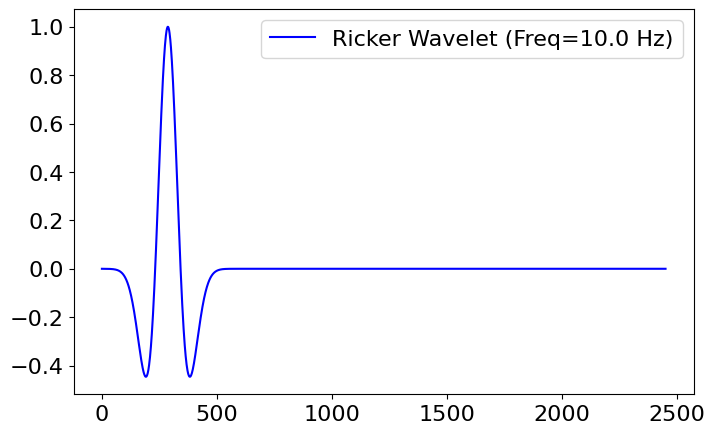

In [56]:
import matplotlib.image as mpimg
# plot the velocity model graph
img = mpimg.imread('/Users/yw11823/ACSE/irp/spyro/ex1_velocity_spyro.png')
fig, ax = plt.subplots(figsize=(10, 6))  # 可以调整figsize的值来设置图形的大小
imgplot = ax.imshow(img)
ax.axis('off')
plt.show()

# plot the graph of the source wavelets
wavelet = spyro.full_ricker_wavelet( dt= dt, tf = tf, freq= freq)
plt.figure(figsize=(8, 5))
plt.plot( wavelet, color='blue', linewidth=1.5, label=f'Ricker Wavelet (Freq={freq} Hz)')
plt.legend()
plt.show()

### 3. Plot shot record

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [-1.10592423e-07  4.70872191e-07  1.11259418e-06 ...  1.08127244e-06
   4.44389095e-07 -1.28422001e-07]
 [-5.40671075e-08  5.58764372e-07  1.22288928e-06 ...  1.19183603e-06
   5.31918777e-07 -7.28460627e-08]
 [ 5.79459469e-09  6.49022825e-07  1.33538794e-06 ...  1.30467744e-06
   6.21894129e-07 -1.38391074e-08]]
(2450, 101)
min: -0.003681863249388824
max: 0.0071767811593709445


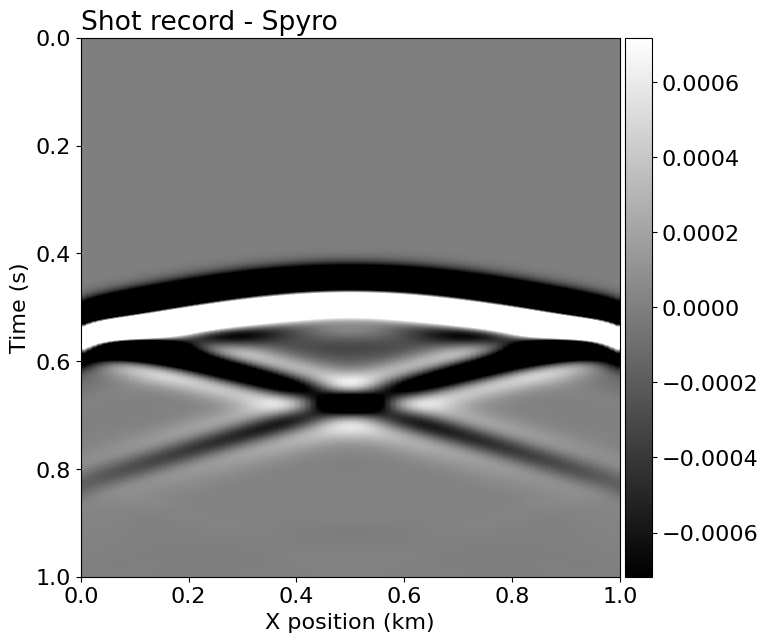

In [57]:
print(p_at_recv)
print(p_at_recv.shape)
print("min:",np.min(p_at_recv))
print("max:",np.max(p_at_recv))
plt.title('Shot record - Spyro', loc='left')
plot_shotrecord(p_at_recv, model, d0, tf) 

### 4. Plot pressure fields

#### 4.1 Numerical analysis

In [80]:
import firedrake as fd
# print an example of pressure field at time step 50
d0 = 600
print("Shape of pressure field at time:", d0, p_field[d0].dat.data.shape)
print("Data of pressure field:", p_field[d0].dat.data)
print("Info of pressure field:", p_field[d0].ufl_domain())
print("lengh of p_field (total time steps):", len(p_field))

# t1 = 500
# print("time in ms:", int(t1 * dt * 1000) )
# print("dt:", dt)
# print("data:", p_field[t1].dat.data)
# fig = fd.tripcolor(p_field[t1], cmap="gray", vmin=-1e-3, vmax=1e-3)  # 绘制压力场
# # tripcolor(p_field[1000], num_sample_points=50)
# plt.colorbar(fig)

Shape of pressure field at time: 600 (90601,)
Data of pressure field: [-5.32663939e-005 -6.30038578e-005 -6.22184657e-005 ... -1.86618442e-163
 -1.89895232e-163 -3.04132505e-165]
Info of pressure field: <Mesh #16875>
lengh of p_field (total time steps): 2450


#### 4.2 Two plots of pressure fields at different timesteps

/var/folders/hx/g9tst_895vb2cxj5f1f0lghh0000gp/T/ipykernel_14247/852164163.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the subplot layout to prevent overlap and leave room for the colorbar


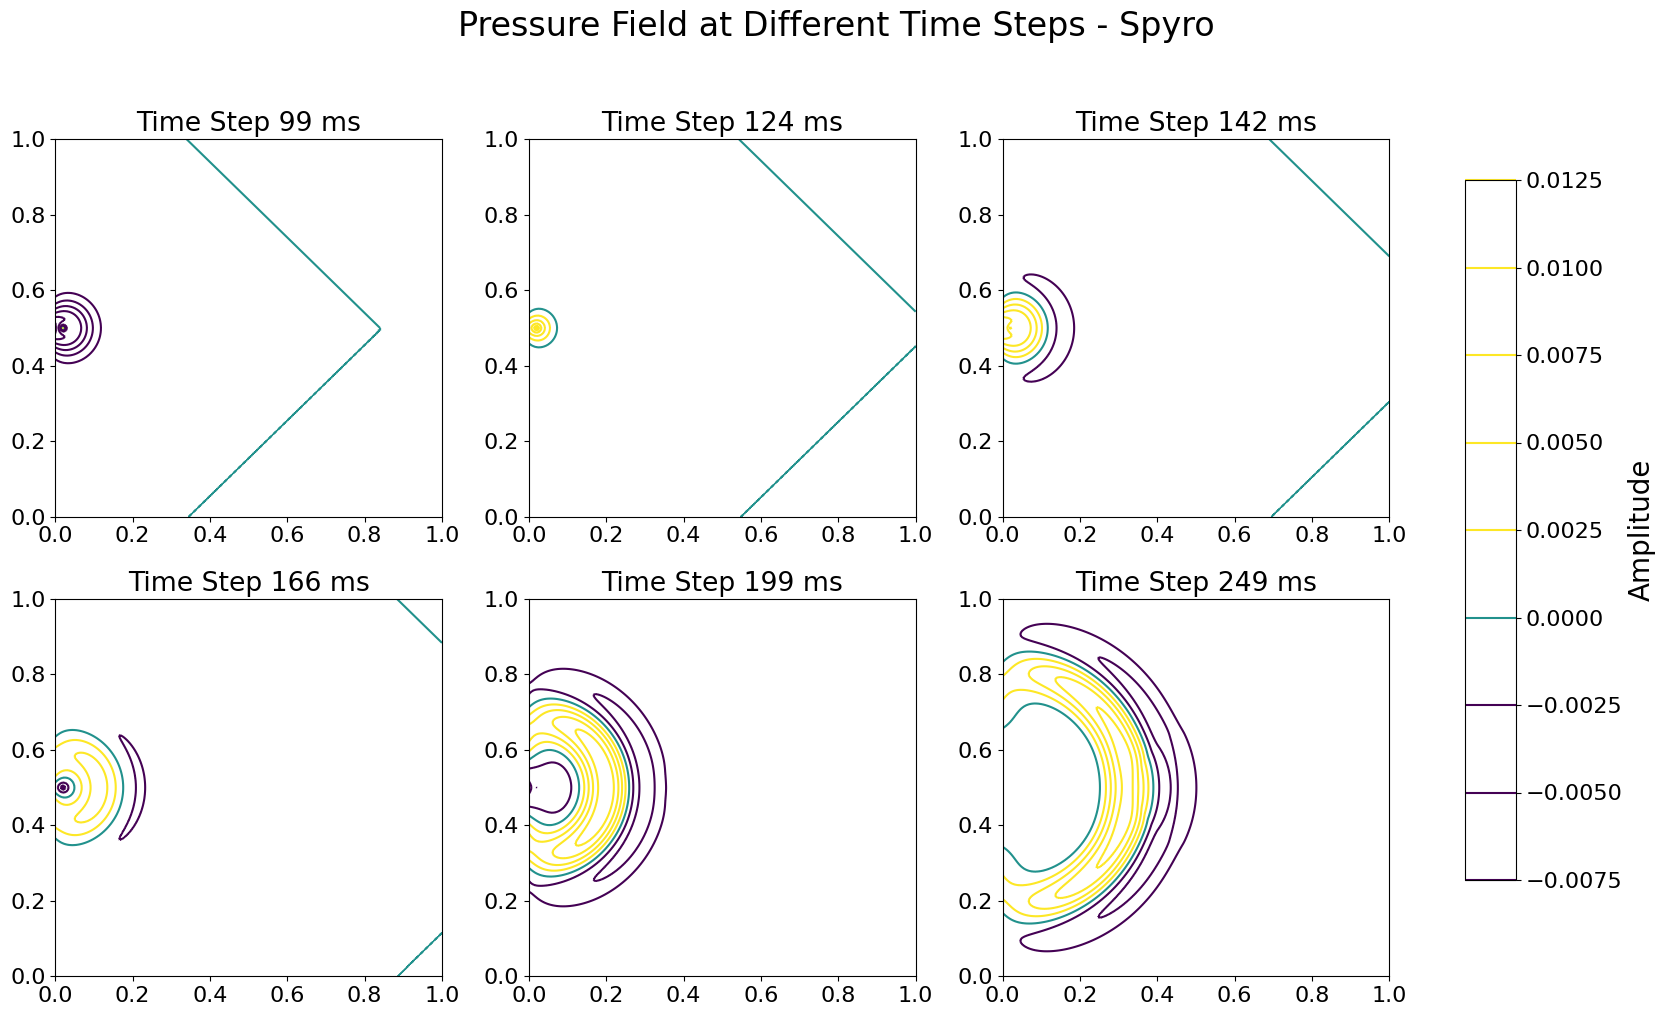

In [77]:
# print the continuous pressure field at a time period
import firedrake as fd

tmax = (tf - d0) / dt
# Define time steps
time_steps = [int(tmax/10), int(tmax/8), int(tmax/7), int(tmax/6), int(tmax/5), int(tmax/4)]
time_taken = [int(t * dt * 1000) for t in time_steps]  # Convert time steps to milliseconds

# Create 2x3 subplots
fig, axes = plt.subplots(2, 3, figsize=(17, 10))

# Iterate over each time step and corresponding axis
for ax, t_index, t_time in zip(axes.flat, time_steps, time_taken):
    colors = fd.tricontour(p_field[t_index], axes=ax, vmin=-1e-3, vmax=1e-3)  # Plot pressure field
    ax.set_title(f"Time Step {t_time} ms")  # Set subplot title

# Add a unified colorbar for all subplots
fig.subplots_adjust(right=0.85)  # Adjust the overall figure layout to make room for the colorbar
cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])  # Position of the colorbar [left, bottom, width, height]
cbar = fig.colorbar(colors, cax=cbar_ax, orientation='vertical')
cbar.set_label('Amplitude', fontsize=20)


fig.suptitle('Pressure Field at Different Time Steps - Spyro', fontsize=24, y=1.02)
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the subplot layout to prevent overlap and leave room for the colorbar
plt.show()

/var/folders/hx/g9tst_895vb2cxj5f1f0lghh0000gp/T/ipykernel_14247/2537685151.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the subplot layout to prevent overlap and leave room for the colorbar


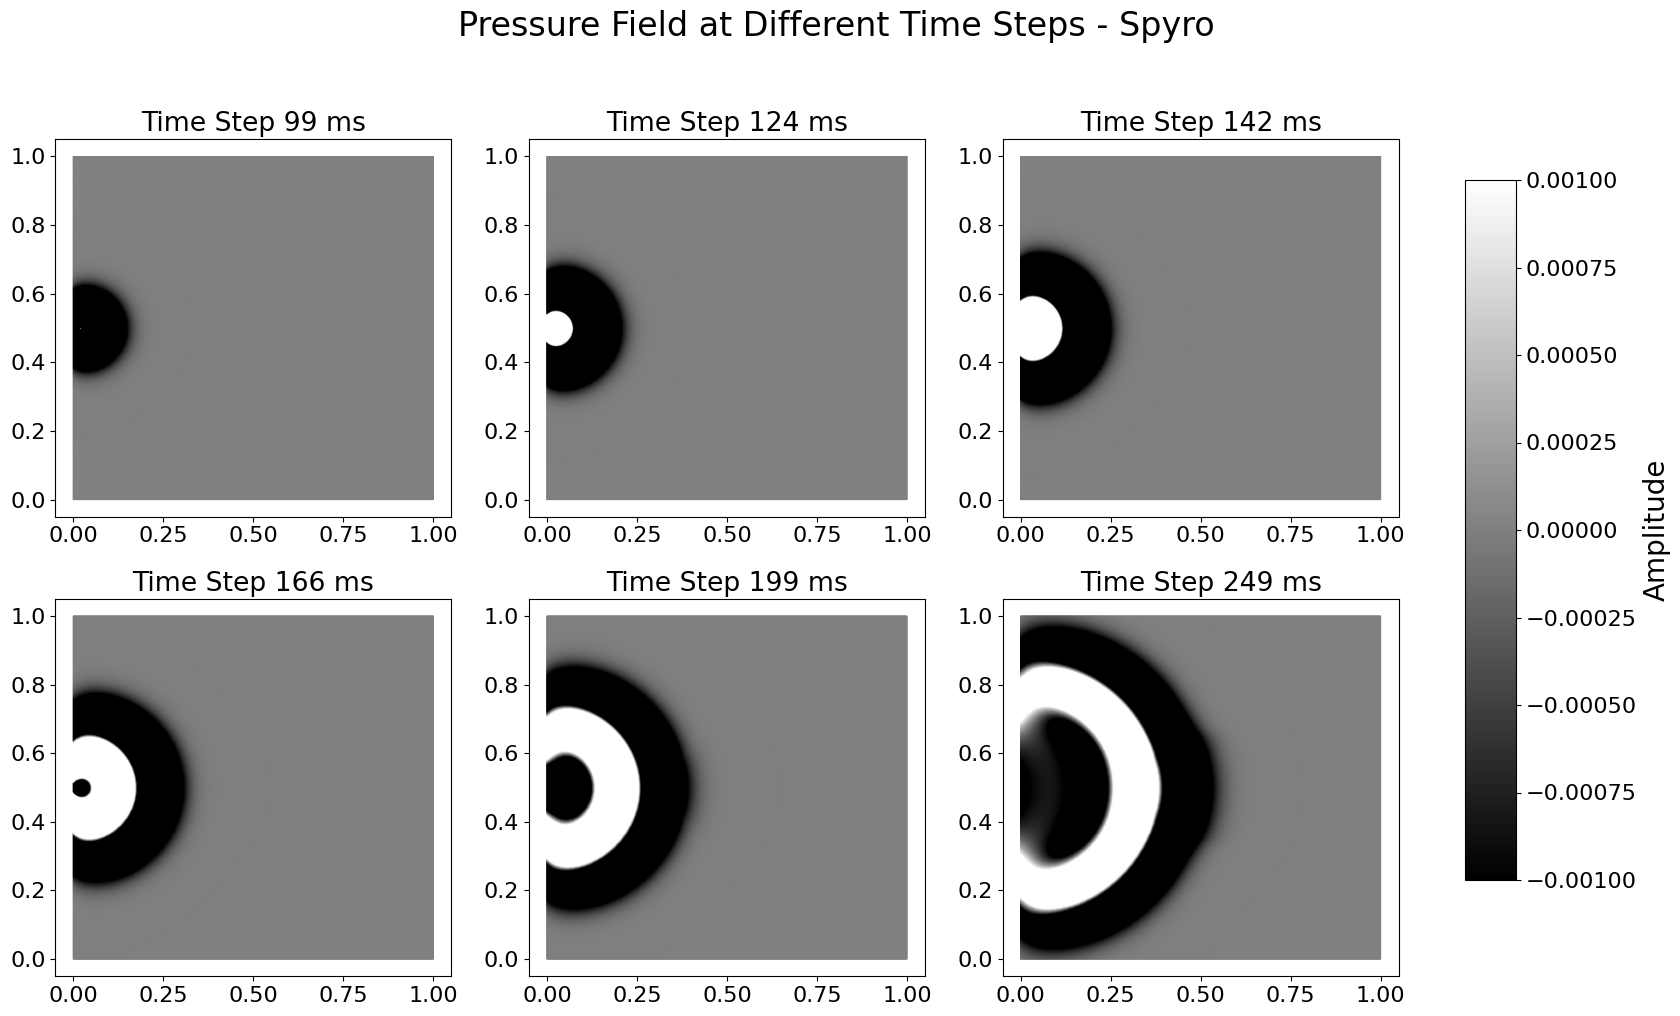

In [78]:
# print the continuous pressure field at a time period
import firedrake as fd

# Define time steps
time_steps = [int(tmax/10), int(tmax/8), int(tmax/7), int(tmax/6), int(tmax/5), int(tmax/4)]
time_taken = [int(t * dt * 1000) for t in time_steps]  # Convert time steps to milliseconds

# Create 2x3 subplots
fig, axes = plt.subplots(2, 3, figsize=(17, 10))

# Iterate over each time step and corresponding axis
for ax, t_index, t_time in zip(axes.flat, time_steps, time_taken):
    colors = fd.tripcolor(p_field[t_index], axes=ax, vmin=-1e-3, vmax=1e-3, cmap="grey")  # Plot pressure field
    ax.set_title(f"Time Step {t_time} ms")  # Set subplot title

# Add a unified colorbar for all subplots
fig.subplots_adjust(right=0.85)  # Adjust the overall figure layout to make room for the colorbar
cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])  # Position of the colorbar [left, bottom, width, height]
cbar = fig.colorbar(colors, cax=cbar_ax, orientation='vertical')
cbar.set_label('Amplitude', fontsize=20)


fig.suptitle('Pressure Field at Different Time Steps - Spyro', fontsize=24, y=1.02)
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the subplot layout to prevent overlap and leave room for the colorbar
plt.show()

## Second Example: Marmousi Model 2D 
### 1. Construct the model, mesh, acquisition geometry
1. sources num = 3
2. receivers num = 101
3. mesh: unit triangular mesh/ using the mesh file corresponding to the true model
4. pml = 0.9 km 
5. Ricker : feq = 5 
6. tf = 2s
7. dt = 0.00025s 
8. p order = 5

In [29]:
number_sou = 3
number_rec = 101
sou = spyro.create_transect((-0.01, 1.0), (-0.01, 15.0), 3) # in km
rev = spyro.create_transect((-0.10, 0.1), (-0.10, 17.0), 101)  # in km

model = {}

model["opts"] = {
    "method": "KMV",  # either CG or KMV
    "quadrature": "KMV",  # Equi or KMV
    "degree": 5,  # p order
    "dimension": 2,  # dimension
}
model["parallelism"] = {
    "type": "spatial",
}
model["mesh"] = {
    "Lz": 3.5,  # depth in km - always positive
    "Lx": 17.0,  # width in km - always positive
    "Ly": 0.0,  # thickness in km - always positive
    "meshfile": "/Users/yw11823/ACSE/irp/spyro/FWI_2D_DATA/meshes/marmousi_exact.msh",
    "initmodel": "not_used.hdf5",
    "truemodel": "/Users/yw11823/ACSE/irp/spyro/FWI_2D_DATA/velocity_models/marmousi_exact.hdf5",
}
model["BCs"] = {
    "status": True,  # True or false
    "outer_bc": "non-reflective",  # None or non-reflective (outer boundary condition)
    "damping_type": "polynomial",  # polynomial, hyperbolic, shifted_hyperbolic
    "exponent": 2,  # damping layer has a exponent variation
    "cmax": 4.5,  # maximum acoustic wave velocity in PML - km/s
    "R": 1e-6,  # theoretical reflection coefficient
    "lz": 0.9,  # thickness of the PML in the z-direction (km) - always positive
    "lx": 0.9,  # thickness of the PML in the x-direction (km) - always positive
    "ly": 0.0,  # thickness of the PML in the y-direction (km) - always positive
}
model["acquisition"] = {
    "source_type": "Ricker",
    "num_sources": number_sou,
    "source_pos": sou,
    "frequency": 5.0,
    "delay": 1.0,
    "num_receivers": number_rec,
    "receiver_locations": rev,
}
model["timeaxis"] = {
    "t0": 0.0,  # Initial time for event
    "tf": 2.00,  # Final time for event
    "dt": 0.00025,
    "amplitude": 1,  # the Ricker has an amplitude of 1.
    "nspool": 10,  # how frequently to output solution to pvds
    "fspool": 1,  # how frequently to save solution to RAM
}

comm = spyro.utils.mpi_init(model)
mesh, V = spyro.io.read_mesh(model, comm)
vp = spyro.io.interpolate(model, mesh, V, guess=False)
if comm.ensemble_comm.rank == 0:
    File("true_velocity.pvd", comm=comm.comm).write(vp)
sources = spyro.Sources(model, mesh, V, comm)
receivers = spyro.Receivers(model, mesh, V, comm)

d0=model["timeaxis"]["t0"]
dt=model["timeaxis"]["dt"]
tf=model["timeaxis"]["tf"]
freq=model["acquisition"]["frequency"]
wavelet = spyro.full_ricker_wavelet(dt=dt,tf=tf,freq=freq,)

start_time = time.time()
p, p_r = spyro.solvers.forward(model, mesh, comm, vp, sources, wavelet, receivers)
end_time = time.time()
running_time = end_time - start_time
print("Running Time: {:.2f} seconds".format(running_time))

# Plot the shot record using the function written in Spyro
spyro.plots.plot_shots(model, comm, p_r, vmin=-1e-5, vmax=1e-5, file_name="M2d_true")
# spyro.plots.plot_shots(model, comm, p_r, vmin=-1e-3, vmax=1e-3)
spyro.io.save_shots(model, comm, p_r, file_name="M2d_true_")

INFO: Distributing 3 shot(s) across 1 core(s). Each shot is using 1 cores
  rank 0 on ensemble 0 owns 7339 elements and can access 3827 vertices


/Users/yw11823/ACSE/irp/firedrake/src/firedrake/firedrake/interpolation.py:385: FutureWarning: The use of `interpolate` to perform the numerical interpolation is deprecated.
This feature will be removed very shortly.

Instead, import `interpolate` from the `firedrake.__future__` module to update
the interpolation's behaviour to return the symbolic `ufl.Interpolate` object associated
with this interpolation.

You can then assemble the resulting object to get the interpolated quantity
of interest. For example,

```
from firedrake.__future__ import interpolate
...

assemble(interpolate(expr, V))
```

Alternatively, you can also perform other symbolic operations on the interpolation operator, such as taking
the derivative, and then assemble the resulting form.

  warnings.warn("""The use of `interpolate` to perform the numerical interpolation is deprecated.


INFO: converting from m/s to km/s


/Users/yw11823/ACSE/irp/firedrake/src/firedrake/firedrake/_deprecation.py:65: UserWarning: The use of `File` for output is deprecated, please update your code to use `VTKFile` from `firedrake.output`.
  warn(
/Users/yw11823/ACSE/irp/firedrake/src/firedrake/firedrake/function.py:325: FutureWarning: The .split() method is deprecated, please use the .subfunctions property instead
  warnings.warn("The .split() method is deprecated, please use the .subfunctions property instead", category=FutureWarning)
/Users/yw11823/ACSE/irp/firedrake/src/ufl/ufl/utils/sorting.py:84: UserWarning: Applying str() to a metadata value of type QuadratureRule, don't know if this is safe.
  warnings.warn(f"Applying str() to a metadata value of type {type(value).__name__}, "
/Users/yw11823/ACSE/irp/firedrake/src/ufl/ufl/utils/sorting.py:84: UserWarning: Applying str() to a metadata value of type QuadratureRule, don't know if this is safe.
  warnings.warn(f"Applying str() to a metadata value of type {type(value)._

Simulation time is:    0.00225 seconds
Simulation time is:    0.00475 seconds
Simulation time is:    0.00725 seconds
Simulation time is:    0.00975 seconds
Simulation time is:    0.01225 seconds
Simulation time is:    0.01475 seconds
Simulation time is:    0.01725 seconds
Simulation time is:    0.01975 seconds
Simulation time is:    0.02225 seconds
Simulation time is:    0.02475 seconds
Simulation time is:    0.02725 seconds
Simulation time is:    0.02975 seconds
Simulation time is:    0.03225 seconds
Simulation time is:    0.03475 seconds
Simulation time is:    0.03725 seconds
Simulation time is:    0.03975 seconds
Simulation time is:    0.04225 seconds
Simulation time is:    0.04475 seconds
Simulation time is:    0.04725 seconds
Simulation time is:    0.04975 seconds
Simulation time is:    0.05225 seconds
Simulation time is:    0.05475 seconds
Simulation time is:    0.05725 seconds
Simulation time is:    0.05975 seconds
Simulation time is:    0.06225 seconds
Simulation time is:    0.

#### runnig by mpiexec -n 8 python m2d_spyro.py 


### 2. Plot the velocity model, source wavelet
velocity model can be visualized in the file true_velocity_model_circle.pvd

In [30]:
### SOME INFOSSS
print(vp.dat.data)
print(vp.dat.data.shape)
print(vp.dat.data.reshape(116,1367))
v4 = vp.dat.data.reshape(116,1367)
print(mesh)
print(mesh.size)

[3.8 3.8 3.8 ... 1.5 1.5 1.5]
(158572,)
[[3.8        3.8        3.8        ... 3.8        3.8        3.8       ]
 [3.8        3.8        3.8        ... 4.5        4.5        4.5       ]
 [4.5        4.5        4.5        ... 3.8        3.8        3.8       ]
 ...
 [1.5        1.5        1.5        ... 1.5        1.50127536 1.5       ]
 [1.5        1.5        1.5        ... 1.5        1.5        1.5       ]
 [1.5        1.5        1.5        ... 1.5        1.5        1.5       ]]
<Mesh #8123>
<bound method AbstractMeshTopology.size of <firedrake.mesh.MeshTopology object at 0x4283ca8d0>>


In [31]:
model['acquisition']['source_pos']

array([[-1.0e-02,  1.0e+00],
       [-1.0e-02,  8.0e+00],
       [-1.0e-02,  1.5e+01]])

In [34]:
# import matplotlib.pyplot as plt
# import numpy as np

# # 假设 vp 是已经插值到有限元空间的速度模型
# # 'sources' 和 'receivers' 包含了源和接收器的位置信息

# # 从 vp.dat.data 提取速度模型数据并进行 reshape
# vp_data = vp.dat.data.reshape((1367, 116))

# # 创建一个图像并设置大小
# fig, ax = plt.subplots(figsize=(8, 12))

# # 绘制速度模型，使用imshow或contourf
# velocity_plot = ax.imshow(vp_data, cmap='viridis')
# cbar = plt.colorbar(velocity_plot, ax=ax, label='Velocity (km/s)')

# # 标记源的位置
# source_x, source_z = zip(*[(pos[0], pos[1]) for pos in model['acquisition']['source_pos']])
# ax.scatter(source_x, source_z, color='red', marker='*', s=100, label='Source')

# # 标记接收器的位置
# receiver_x, receiver_z = zip(*[(pos[0], pos[1]) for pos in model['acquisition']['receiver_locations']])
# ax.scatter(receiver_x, receiver_z, color='yellow', marker='v', s=50, label='Receiver')

# # 设置图像的标签和标题
# ax.set_xlabel('X position (km)')
# ax.set_ylabel('Depth (km)')
# ax.set_title('Velocity Model with Sources and Receivers')
# ax.legend()

# # 显示图像
# plt.show()


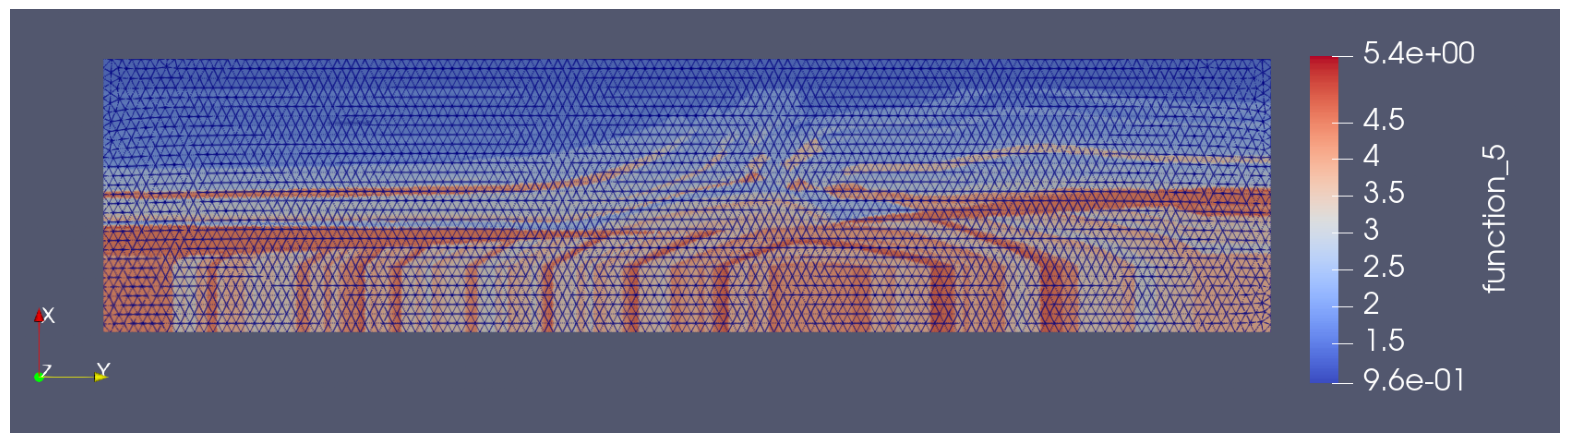

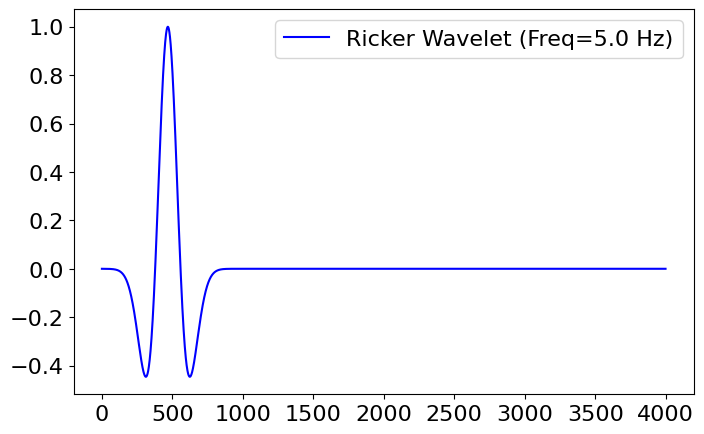

In [8]:
import matplotlib.image as mpimg
# plot the velocity model graph
img = mpimg.imread('/Users/yw11823/ACSE/irp/spyro/M2d_velocity_spyro.png')
fig, ax = plt.subplots(figsize=(20, 8))  # 可以调整figsize的值来设置图形的大小
imgplot = ax.imshow(img)
ax.axis('off')
plt.show()

# plot the graph of the source wavelets
wavelet = spyro.full_ricker_wavelet( dt= dt, tf = tf, freq= freq)
plt.figure(figsize=(8, 5))
plt.plot( wavelet, color='blue', linewidth=1.5, label=f'Ricker Wavelet (Freq={freq} Hz)')
plt.legend()
plt.show()

### 3. Plot the shot record
based on the results from ```m2d_spyro.py``` 

#### But there is no difference between ```shot_record_1.dat``` and ```shot_record_2.dat``` ???????

In [19]:
p[100].dat.data

array([0., 0., 0., ..., 0., 0., 0.])

In [20]:
p_r

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-1.21235621e-04, -1.99163113e-04, -2.57965150e-05, ...,
        -1.33140995e-14,  5.75005265e-15,  2.82296375e-15],
       [-1.21409992e-04, -1.98311194e-04, -2.52874269e-05, ...,
        -1.33126699e-14,  5.89129536e-15,  2.76011955e-15],
       [-1.21582658e-04, -1.97456581e-04, -2.47831438e-05, ...,
        -1.33008428e-14,  6.02925057e-15,  2.69477272e-15]])

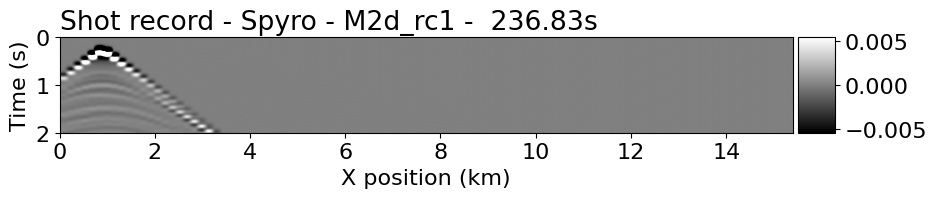

In [36]:
plt.title('Shot record - Spyro - M2d_rc1 -  236.83s', loc='left')
plot_shotrecord(p_r, model, d0, tf) 

<!-- 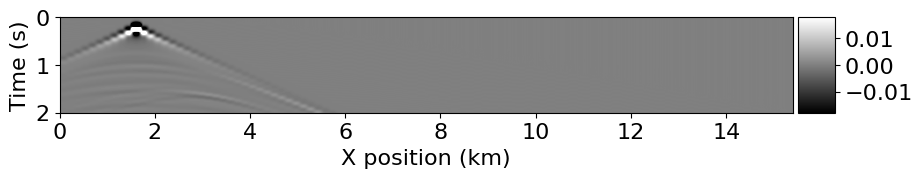 
with the origin condition -->

In [11]:
# p_r_1 = load_shots(file_name="/Users/yw11823/ACSE/irp/spyro/paper/M2d_true_shot_record_1.dat")
# print(p_r_1)
# print(p_r_1.shape)
# print("min:",np.min(p_r_1))
# print("max:",np.max(p_r_1))
# plt.title('Shot record - Spyro - M2d_rc1 -  236.83s', loc='left')
# plot_shotrecord(p_r_1, model, d0, tf) 


In [12]:
# p_r_1 = load_shots(file_name="/Users/yw11823/ACSE/irp/spyro/paper/M2d_true_shot_record_1.dat")
# print(p_r_1)
# print(p_r_1.shape)
# print("min:",np.min(p_r_1))
# print("max:",np.max(p_r_1))
# plt.title('Shot record - Spyro - M2d_rc1 -  236.83s', loc='left')
# plot_shotrecord(p_r_1, model, d0, tf) 

# p_r_2 = load_shots(file_name="/Users/yw11823/ACSE/irp/spyro/paper/M2d_true_shot_record_2.dat")
# print(p_r_2)
# print(p_r_2.shape)
# print("min:",np.min(p_r_2))
# print("max:",np.max(p_r_2))
# plt.title('Shot record - Spyro with running time  236.83', loc='left')
# plot_shotrecord(p_r_2, model, d0, tf) 

### 4. Plot pressure fields

This pressure field looks strange because it is rotated 90 degrees in the Spyro system. To facilitate observation, we also rotate it 90 degrees here.

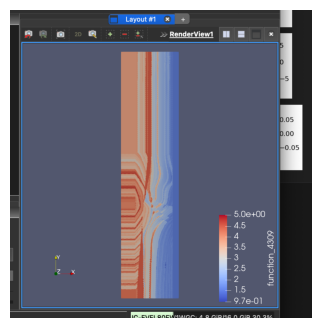

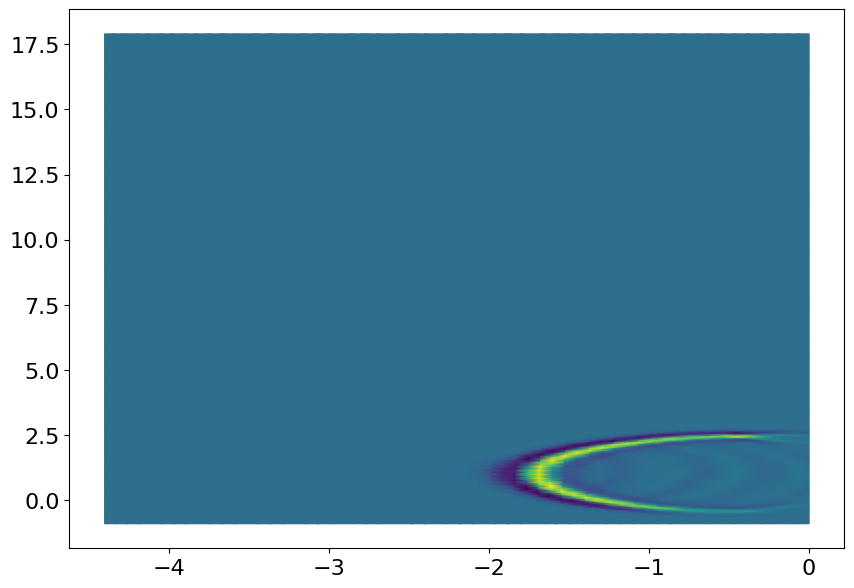

In [37]:
import matplotlib.image as mpimg
# plot the velocity model graph
img = mpimg.imread('/Users/yw11823/ACSE/irp/spyro/normal coordinate nspyro.png')
fig, ax = plt.subplots(figsize=(10, 4))  # 可以调整figsize的值来设置图形的大小
imgplot = ax.imshow(img)
ax.axis('off')
plt.show()

firedrake.tripcolor(p[5000])

In [40]:
np.min(p[10].dat.data)
p[10].dat.data
print(len(p))

8000


Shape of pressure field at time: 0.0 (158572,)
Data of pressure field: [0. 0. 0. ... 0. 0. 0.]
Info of pressure field: <Mesh #8123>
lengh of p_field (total time steps): 8000
time in ms: 1000
dt: 0.00025
data: [ 7.22021761e-53  2.22928809e-53  3.85086937e-53 ...  4.84787083e-12
  2.37138117e-12 -1.68412008e-11]


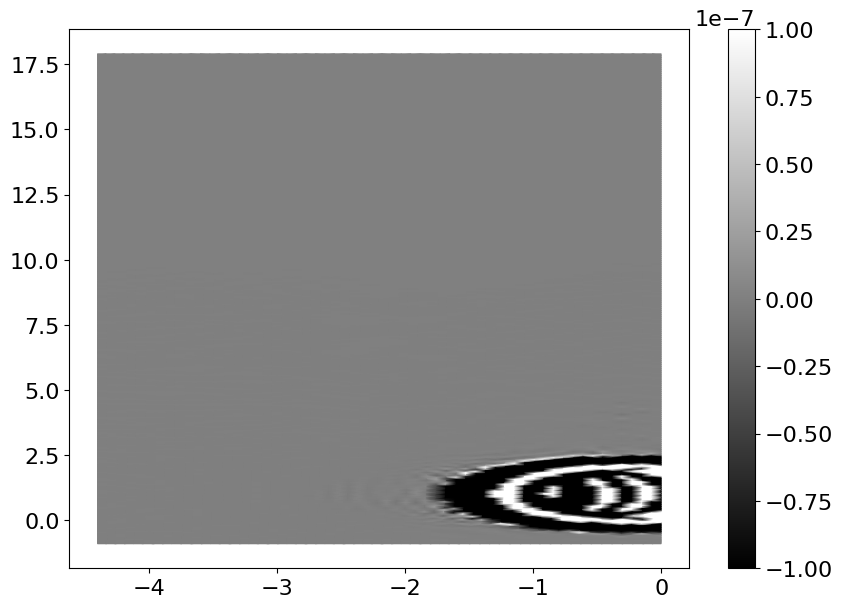

In [41]:
import firedrake as fd

# Print the shape of the pressure field at time step t0.
print("Shape of pressure field at time:", d0, p[10].dat.data.shape)
# Print the data of the pressure field at time step t0.
print("Data of pressure field:", p[10].dat.data)
# Print additional info about the pressure field's domain at time step t0.
print("Info of pressure field:", p[10].ufl_domain())
print("lengh of p_field (total time steps):", len(p))

t1 = 4000
print("time in ms:", int(t1 * dt * 1000) )
print("dt:", dt)
print("data:", p[t1].dat.data)
fig = fd.tripcolor(p[t1], cmap="gray", vmin=-1e-7, vmax=1e-7)  # 绘制压力场
# tripcolor(p_field[1000], num_sample_points=50)
plt.colorbar(fig)

/var/folders/hx/g9tst_895vb2cxj5f1f0lghh0000gp/T/ipykernel_86818/832977734.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the subplot layout to prevent overlap and leave room for the colorbar


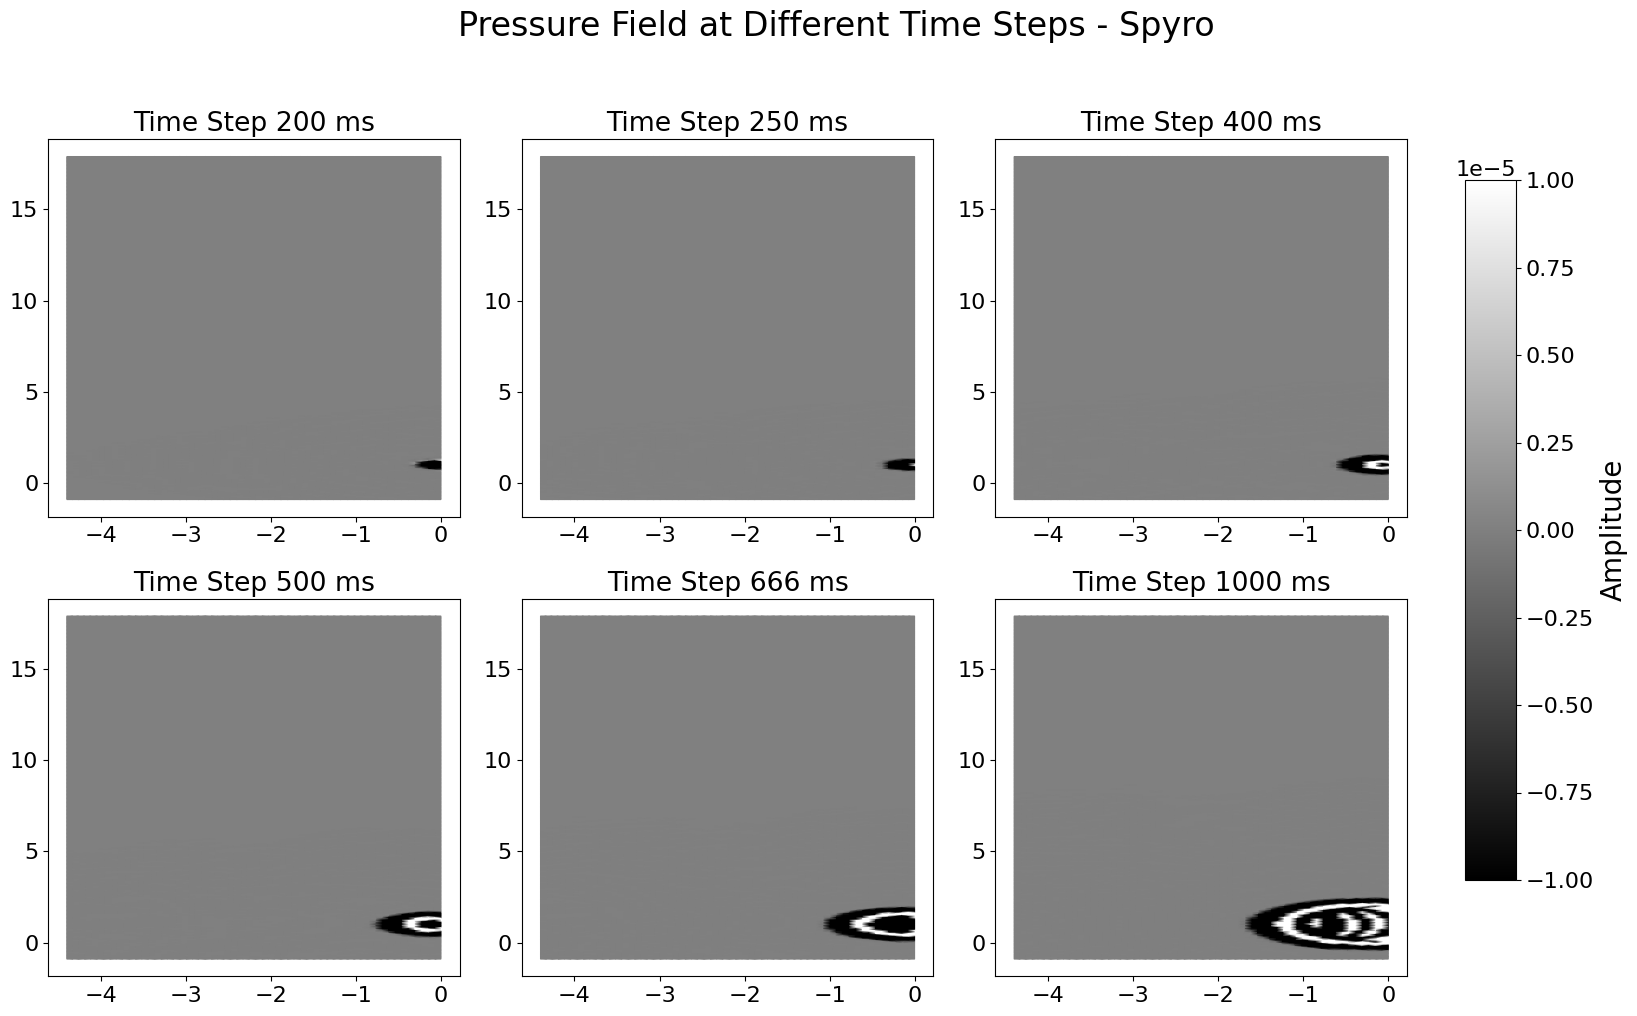

In [43]:
import firedrake as fd
tmax = (tf - d0) / dt
# Define time steps
time_steps = [int(tmax/10), int(tmax/8), int(tmax/5), int(tmax/4), int(tmax/3), int(tmax/2)]

# time_steps = [999, 1990, 2499, 3329, 4999, 9999]
time_taken = [int(t * dt * 1000) for t in time_steps]  # Convert time steps to milliseconds

# Create 2x3 subplots
fig, axes = plt.subplots(2, 3, figsize=(17, 10))

# Iterate over each time step and corresponding axis
for ax, t_index, t_time in zip(axes.flat, time_steps, time_taken):
    colors = fd.tripcolor(p[t_index], axes=ax, vmin=-1e-5, vmax=1e-5, cmap="grey")  # Plot pressure field
    ax.set_title(f"Time Step {t_time} ms")  # Set subplot title

# Add a unified colorbar for all subplots
fig.subplots_adjust(right=0.85)  # Adjust the overall figure layout to make room for the colorbar
cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])  # Position of the colorbar [left, bottom, width, height]
cbar = fig.colorbar(colors, cax=cbar_ax, orientation='vertical')
cbar.set_label('Amplitude', fontsize=20)


fig.suptitle('Pressure Field at Different Time Steps - Spyro', fontsize=24, y=1.02)
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the subplot layout to prevent overlap and leave room for the colorbar
plt.show()

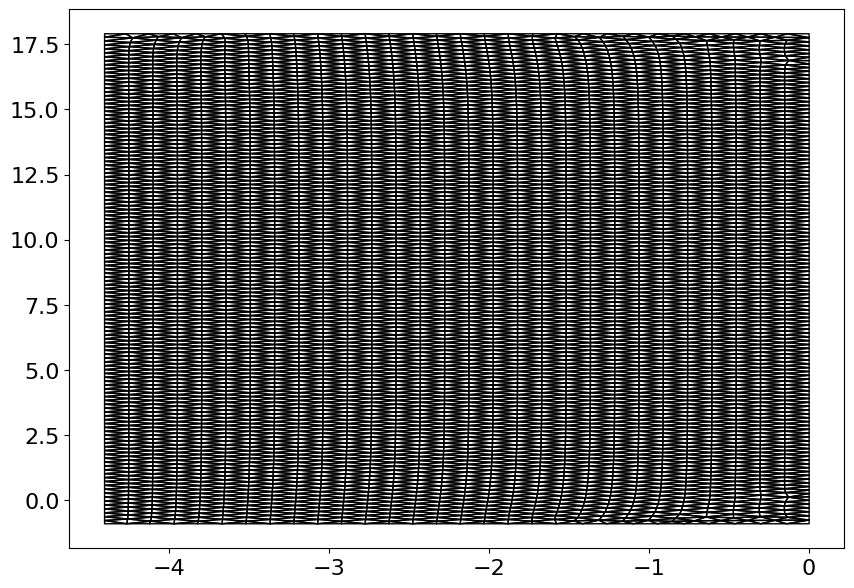

In [53]:
fd.triplot(mesh, axes=None, interior_kw={}, boundary_kw={})

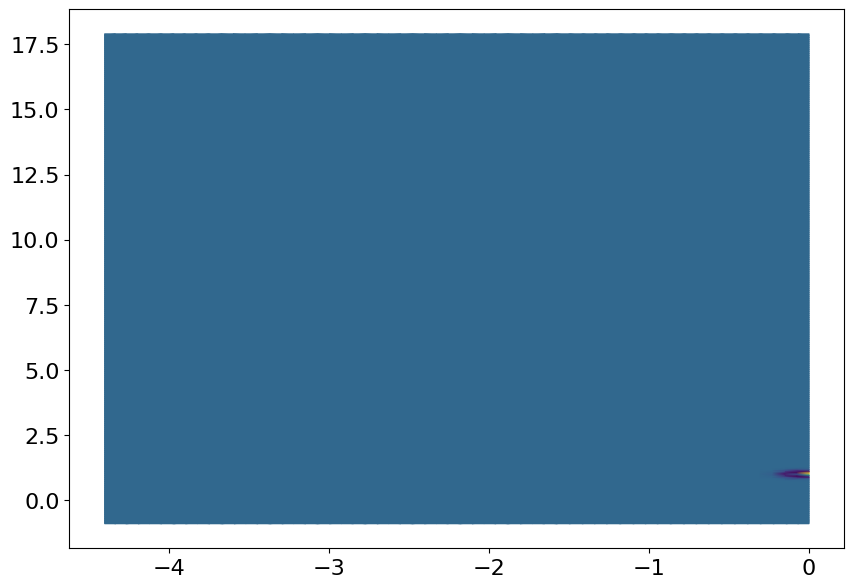

In [58]:
fd.tripcolor(p[1000])

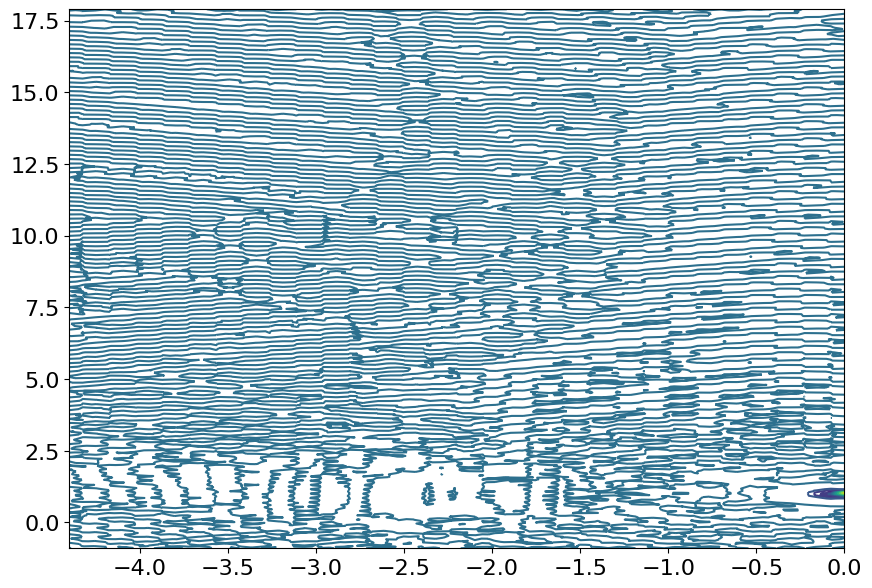

In [60]:
fd.tricontour(p[1000], levels=10)

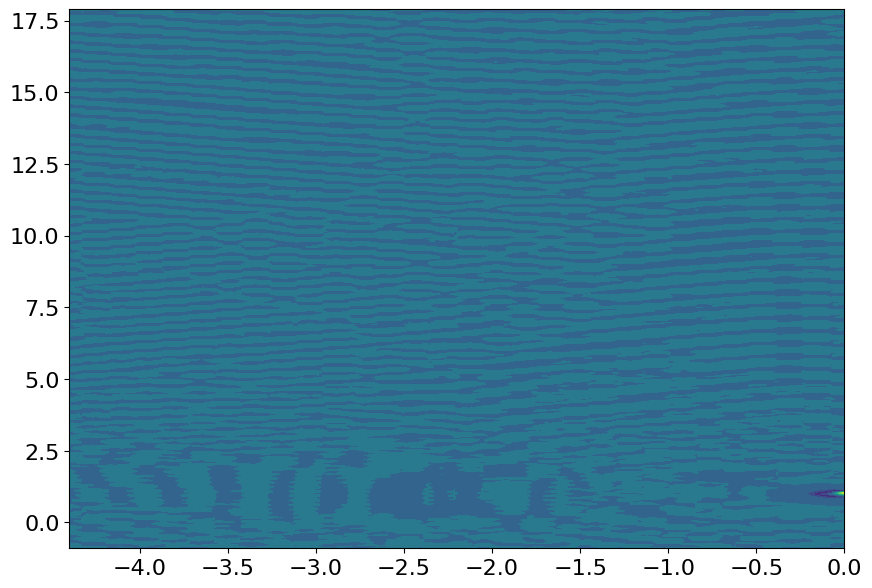

In [61]:
fd.tricontourf(p[1000], levels=10)

In [ ]:
len(p)
p_100 = p[100].dat.data.shape
print(p_100)
p_100.reshape((1367, 116))

In [ ]:
comm = spyro.utils.mpi_init(model)
mesh, V = spyro.io.read_mesh(model, comm)
vp = spyro.io.interpolate(model, mesh, V, guess=False)
if comm.ensemble_comm.rank == 0:
    File("true_velocity.pvd", comm=comm.comm).write(vp)
sources = spyro.Sources(model, mesh, V, comm)
receivers = spyro.Receivers(model, mesh, V, comm)

In [87]:
vp.ufl_shape
vp.ufl_id
vp.ufl_element

<bound method BaseCoefficient.ufl_element of Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x4283ca8d0>, FiniteElement('Kong-Mulder-Veldhuizen', triangle, 5, variant='KMV'), name=None), Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 8123)), 16261)>